# Processing FITS images in Hubble Archive at http://hla.stsci.edu/

In [39]:
import os
import numpy as np
from scipy import interpolate as si

from PIL import Image
from PIL import ImageFilter
from PIL import ImageEnhance

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import astropy
from astropy import wcs
from astropy.io import fits
from astropy import units as u
from astropy import coordinates

In [177]:
image_dir = 'D://Hubble//hst_09489_01_wfpc2//'
files = os.listdir(image_dir)

out = './/out//'

## Open Image

In [178]:
def collect_FITS_data(fits_image_filename):

    hdul = fits.open(fits_image_filename)

    header = np.array((hdul[0].header,hdul[1].header))

    print("Telescope pointing right ascension: {0:.4f}°".format(header[0]['RA_TARG']))
    
    print("Telescope pointing declination: {0:.4f}°".format(header[0]['DEC_TARG']))

    # Collecting image data
    image_data = hdul[1].data

    print("Size of picture:", image_data.shape)

    # World coordinates of corners
    ImageWCS = wcs.WCS(header[1])

    # image size: (X, Y)
    # image_data.shape[0] = Y
    # image_data.shape[1] = X
    #                      #  X coordinates     #  Y coordinates                               # X # Y
    corner_coordinates = [[0,                   0],                      # Upper left corner    (0,  0) - origo
                          [0,                   image_data.shape[0]],    # Bottom left corner   (0,  Y)
                          [image_data.shape[1], 0],                      # Upper right corner   (X,  0)
                          [image_data.shape[1], image_data.shape[0]]]    # Bottom right corner  (X,  Y)

    corner_coordinates = np.array(corner_coordinates)
    
    # Never use this wcs_pix2world, it's literally shit
    world_coords = ImageWCS.wcs_pix2world(corner_coordinates, 0, ra_dec_order=True)
    
    # Convert corner pixel coordinates into sky-coordinates
    sky_coords = wcs.utils.pixel_to_skycoord(xp=corner_coordinates[:,0], yp=corner_coordinates[:,1], wcs=ImageWCS, origin=0)
    
    # Covert back to pixels from wcs for checking
    corner_coordinates_new = ImageWCS.wcs_world2pix(world_coords, 0, ra_dec_order=True)
    
    for i in range(corner_coordinates_new.shape[0]):
        for j in range(corner_coordinates_new.shape[1]):
            corner_coordinates_new[i][j] = int(corner_coordinates_new[i][j])

    return image_data, header, corner_coordinates, world_coords, sky_coords, corner_coordinates_new

In [179]:
def plot_corner_info(corner_coordinates, corner_coordinates_new, world_coords, sky_coords):
    
    print('''Corners\' pixel coordinates:
             Upper left corner: {0}
             Bottom left corner: {1}
             Upper right corner: {2}
             Bottom right corner: {3}\n'''.format(corner_coordinates[0],
                                                  corner_coordinates[1],
                                                  corner_coordinates[2],
                                                  corner_coordinates[3]))
    print('''Corners\' pixel coordinates after conversion:
             Upper left corner: {0}
             Bottom left corner: {1}
             Upper right corner: {2}
             Bottom right corner: {3}\n'''.format(corner_coordinates_new[0],
                                                  corner_coordinates_new[1],
                                                  corner_coordinates_new[2],
                                                  corner_coordinates_new[3]))
    print('''Corners\' world coordinates:
             Upper left corner: {0}
             Bottom left corner: {1}
             Upper right corner: {2}
             Bottom right corner: {3}\n'''.format(world_coords[0],
                                                  world_coords[1],
                                                  world_coords[2],
                                                  world_coords[3]))
    print('''Corners\' sky coordinates:
             Upper left corner: [{0} {1}]
             Bottom left corner: [{2} {3}]
             Upper right corner: [{4} {5}]
             Bottom right corner: [{6} {7}]\n'''.format(sky_coords[0].ra.deg, sky_coords[0].dec.deg,
                                                        sky_coords[1].ra.deg, sky_coords[1].dec.deg,
                                                        sky_coords[2].ra.deg, sky_coords[2].dec.deg,
                                                        sky_coords[3].ra.deg, sky_coords[3].dec.deg))

In [183]:
def plot_image(image_data, corner_coordinates, sky_coords):

    axislabelsize = 23
    axisticksize = 20
    scattersize = 200
    legendsize = 20

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,20))

    # From histogram
    image = axes.imshow(image_data, cmap='Greys_r', vmin=0, vmax=30)
    #image = axes.imshow(np.log10(image_data), cmap='Greys_r')

    axes.set_xticks([])
    axes.set_yticks([])
    axes.tick_params(axis='both', which='major', labelsize=20)

    plt.show()

In [184]:
fits_image_filename = image_dir + files[0]

image_data, \
header, \
corner_coordinates, \
world_coords, \
sky_coords, \
corner_coordinates_new = collect_FITS_data(fits_image_filename)

Telescope pointing right ascension: 337.4074°
Telescope pointing declination: -20.8004°
Size of picture: (800, 800)


c:\users\masterdesky\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
c:\users\masterdesky\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':


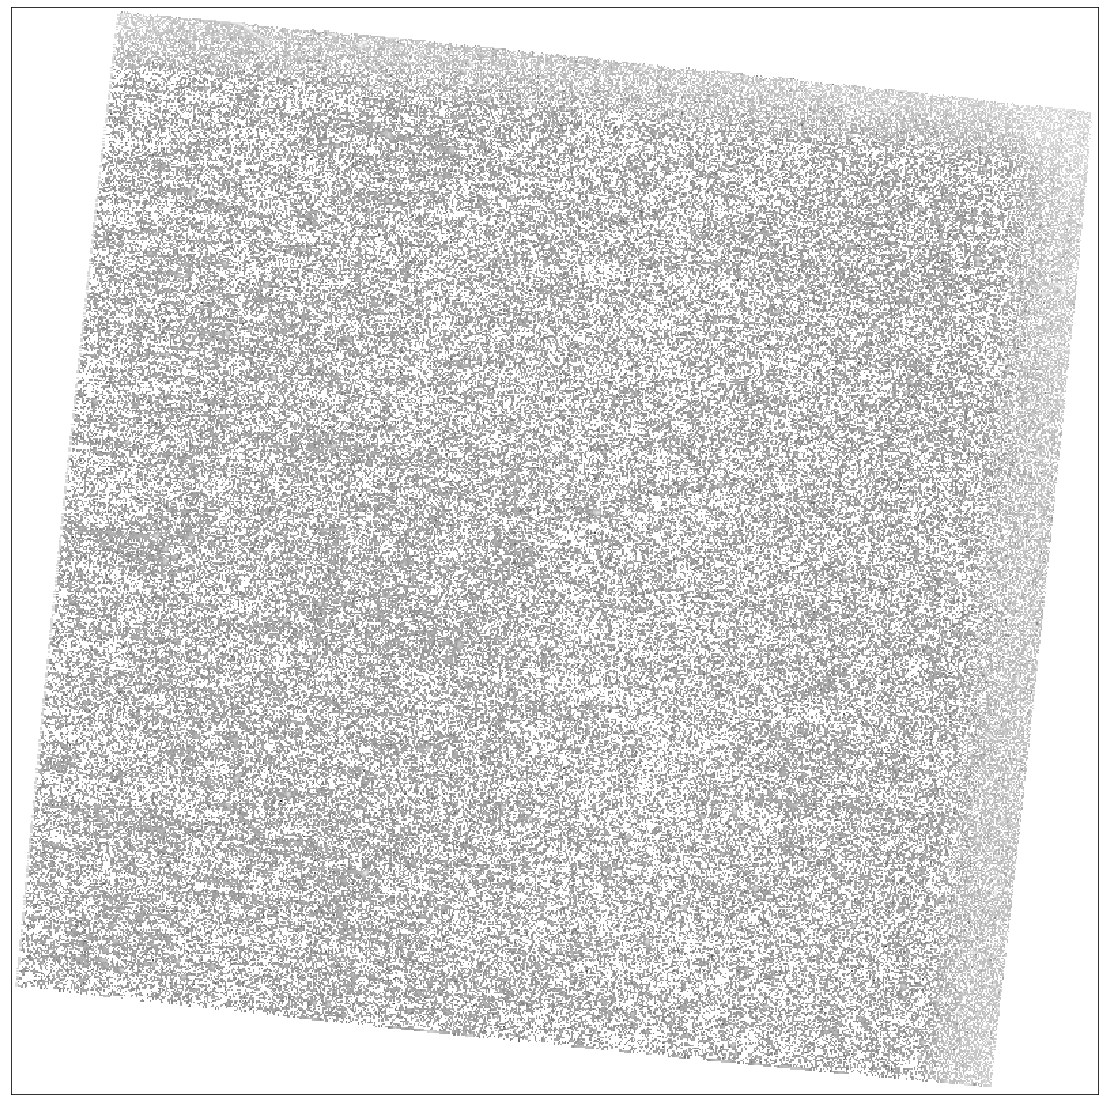

In [185]:
plot_image(image_data, corner_coordinates, sky_coords)

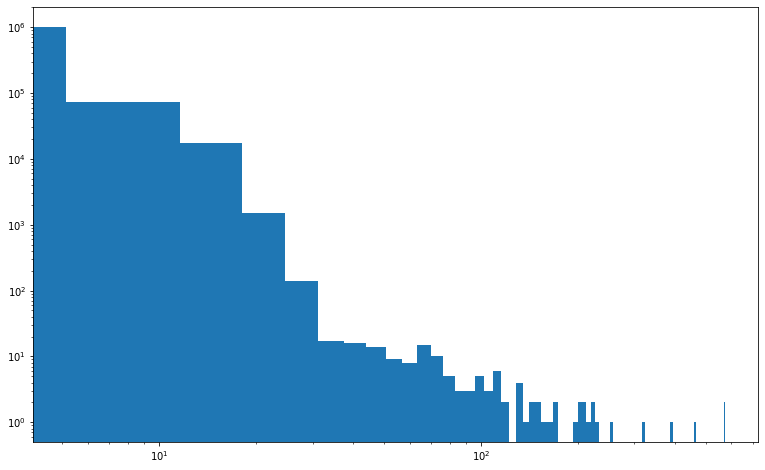

In [8]:
fig, axes = plt.subplots(figsize=(13,8))

axes.hist(image_data.flatten(), bins=100)

axes.set_xscale('log')
axes.set_yscale('log')

plt.show()

## Stack channels

In [107]:
img_1 = collect_FITS_data(image_dir + files[0])[0]
img_2 = collect_FITS_data(image_dir + files[1])[0]
img_3 = collect_FITS_data(image_dir + files[2])[0]

Telescope pointing right ascension: 269.6387°
Telescope pointing declination: 66.6328°
Size of picture: (1050, 1050)
Telescope pointing right ascension: 269.6387°
Telescope pointing declination: 66.6328°
Size of picture: (1050, 1050)
Telescope pointing right ascension: 269.6387°
Telescope pointing declination: 66.6328°
Size of picture: (1050, 1050)


In [164]:
vmin_b = 0
vmax_b = 20

vmin_g = 0
vmax_g = 28

vmin_r = 0
vmax_r = 14

# Resize images
img_1_res = img_1.copy()
img_2_res = img_2.copy()
img_3_res = img_3.copy()

img_1_res[img_1_res <= vmin_b] = vmin_b
img_1_res[img_1_res >= vmax_b] = vmax_b
img_2_res[img_2_res <= vmin_g] = vmin_g
img_2_res[img_2_res >= vmax_g] = vmax_g
img_3_res[img_3_res <= vmin_r] = vmin_r
img_3_res[img_3_res >= vmax_r] = vmax_r

In [165]:
# Image filters  |  In HST images  |  In reality        |
# ------------------------------------------------------|
# img_1 : F502   |  Used as Blue   |  Appears Green     |
# img_2 : F656   |  Used as Green  |  Appears Red       |
# img_3 : F658   |  Used as Red    |  Appears Deep red  |

b = img_1_res/np.max(img_1_res)
g = img_2_res/np.max(img_2_res)
r = img_3_res/np.max(img_3_res)
    
img_ch = (np.dstack((r, g, b)) * 255.999).astype('uint8')

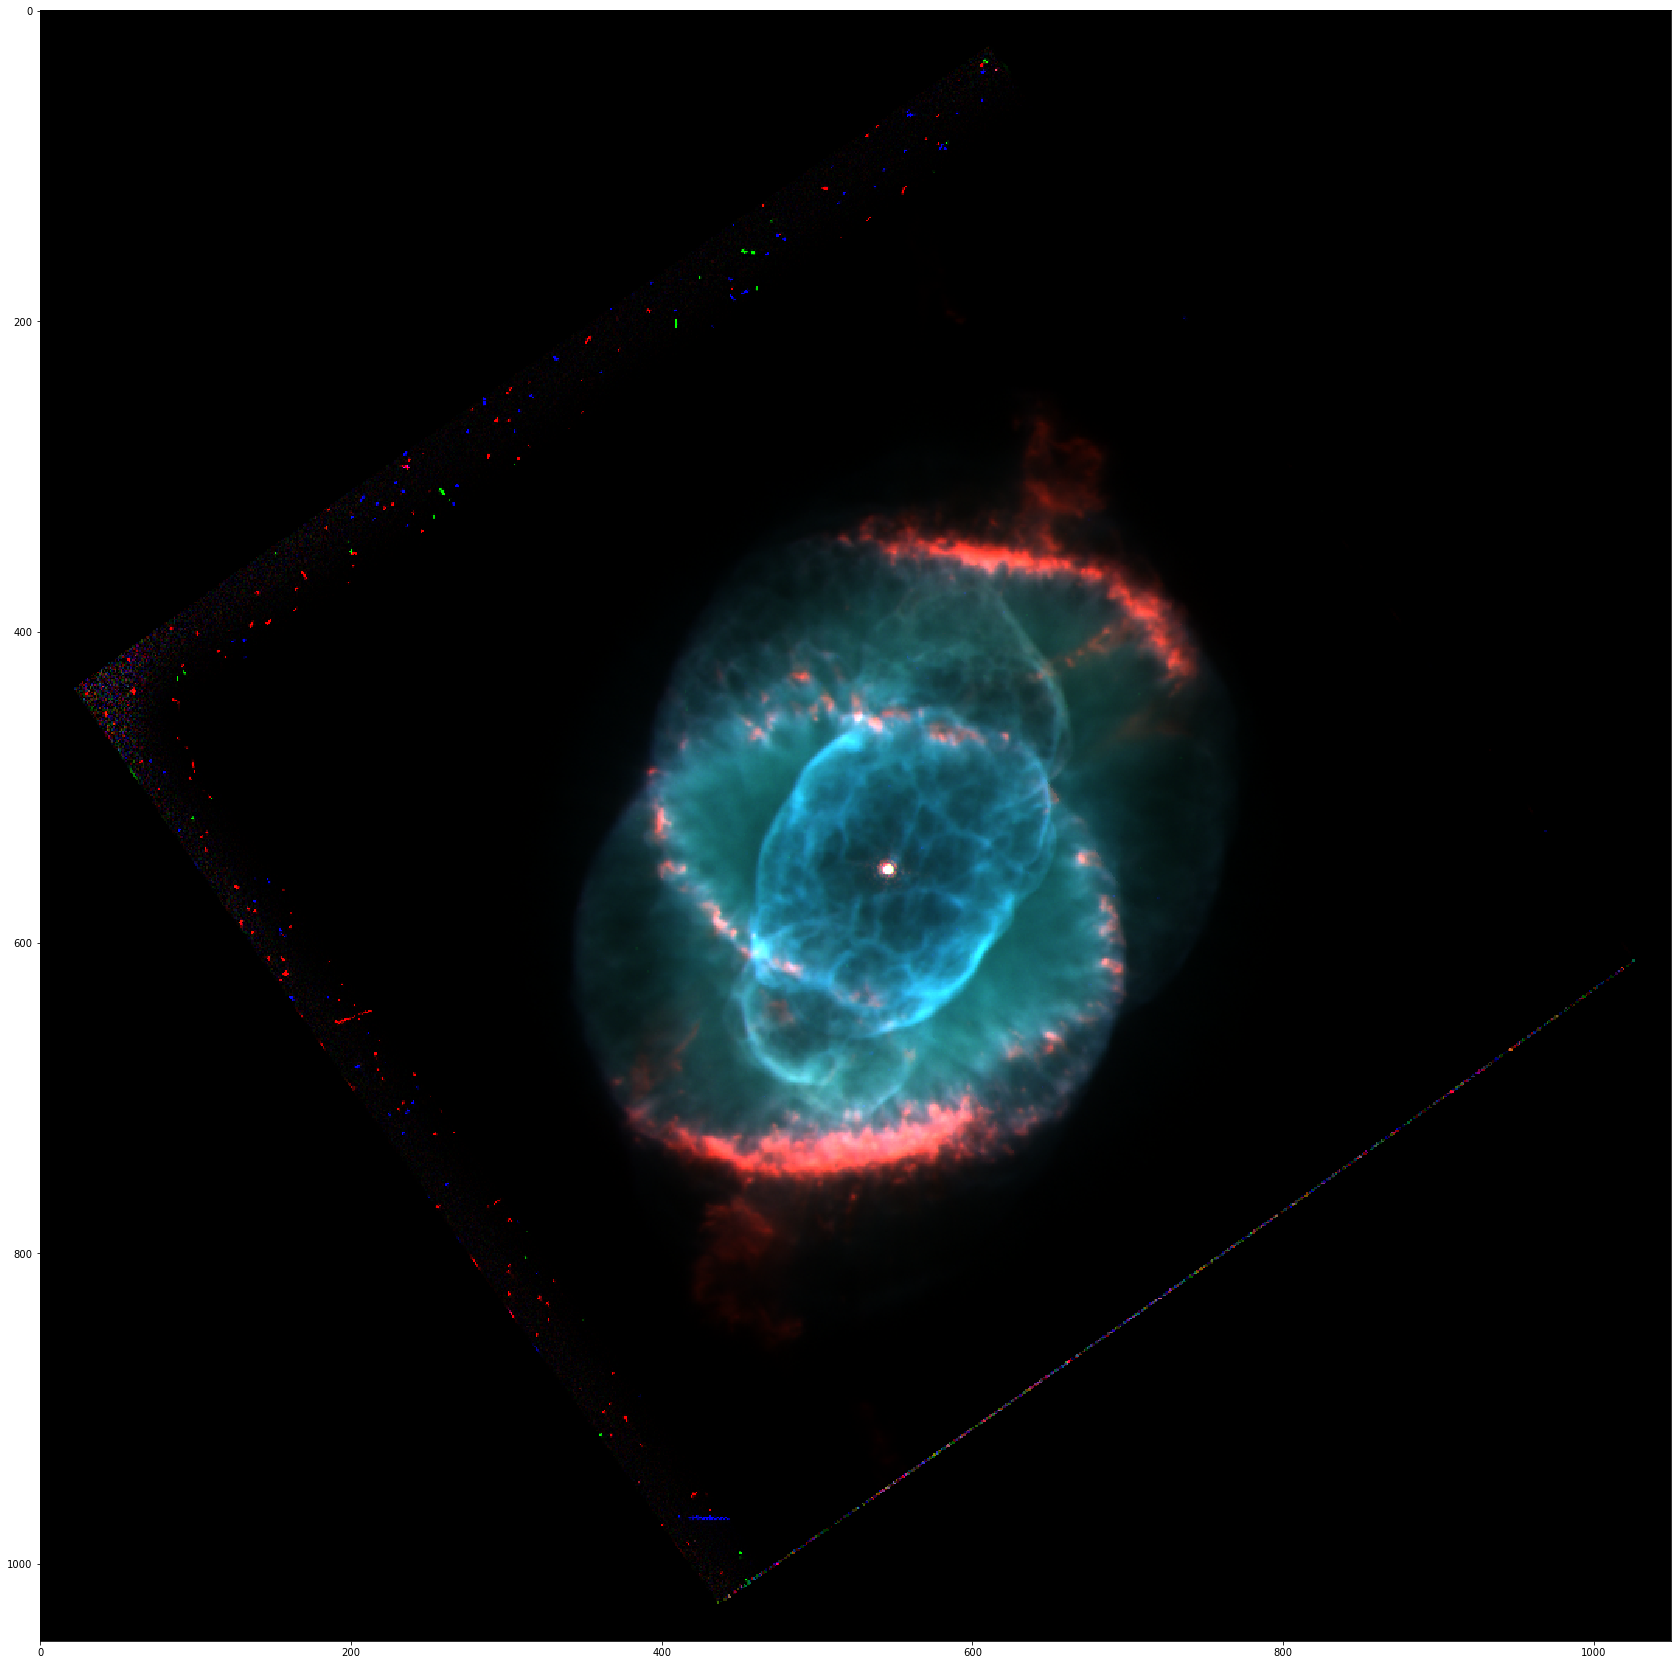

In [166]:
fig, axes = plt.subplots(figsize=(30,30))

axes.imshow(img_ch)

plt.imsave(out + 'rgb_raw.png', img_ch)

plt.show()

In [174]:
img_ch_load = Image.open(out + 'rgb_raw.png')

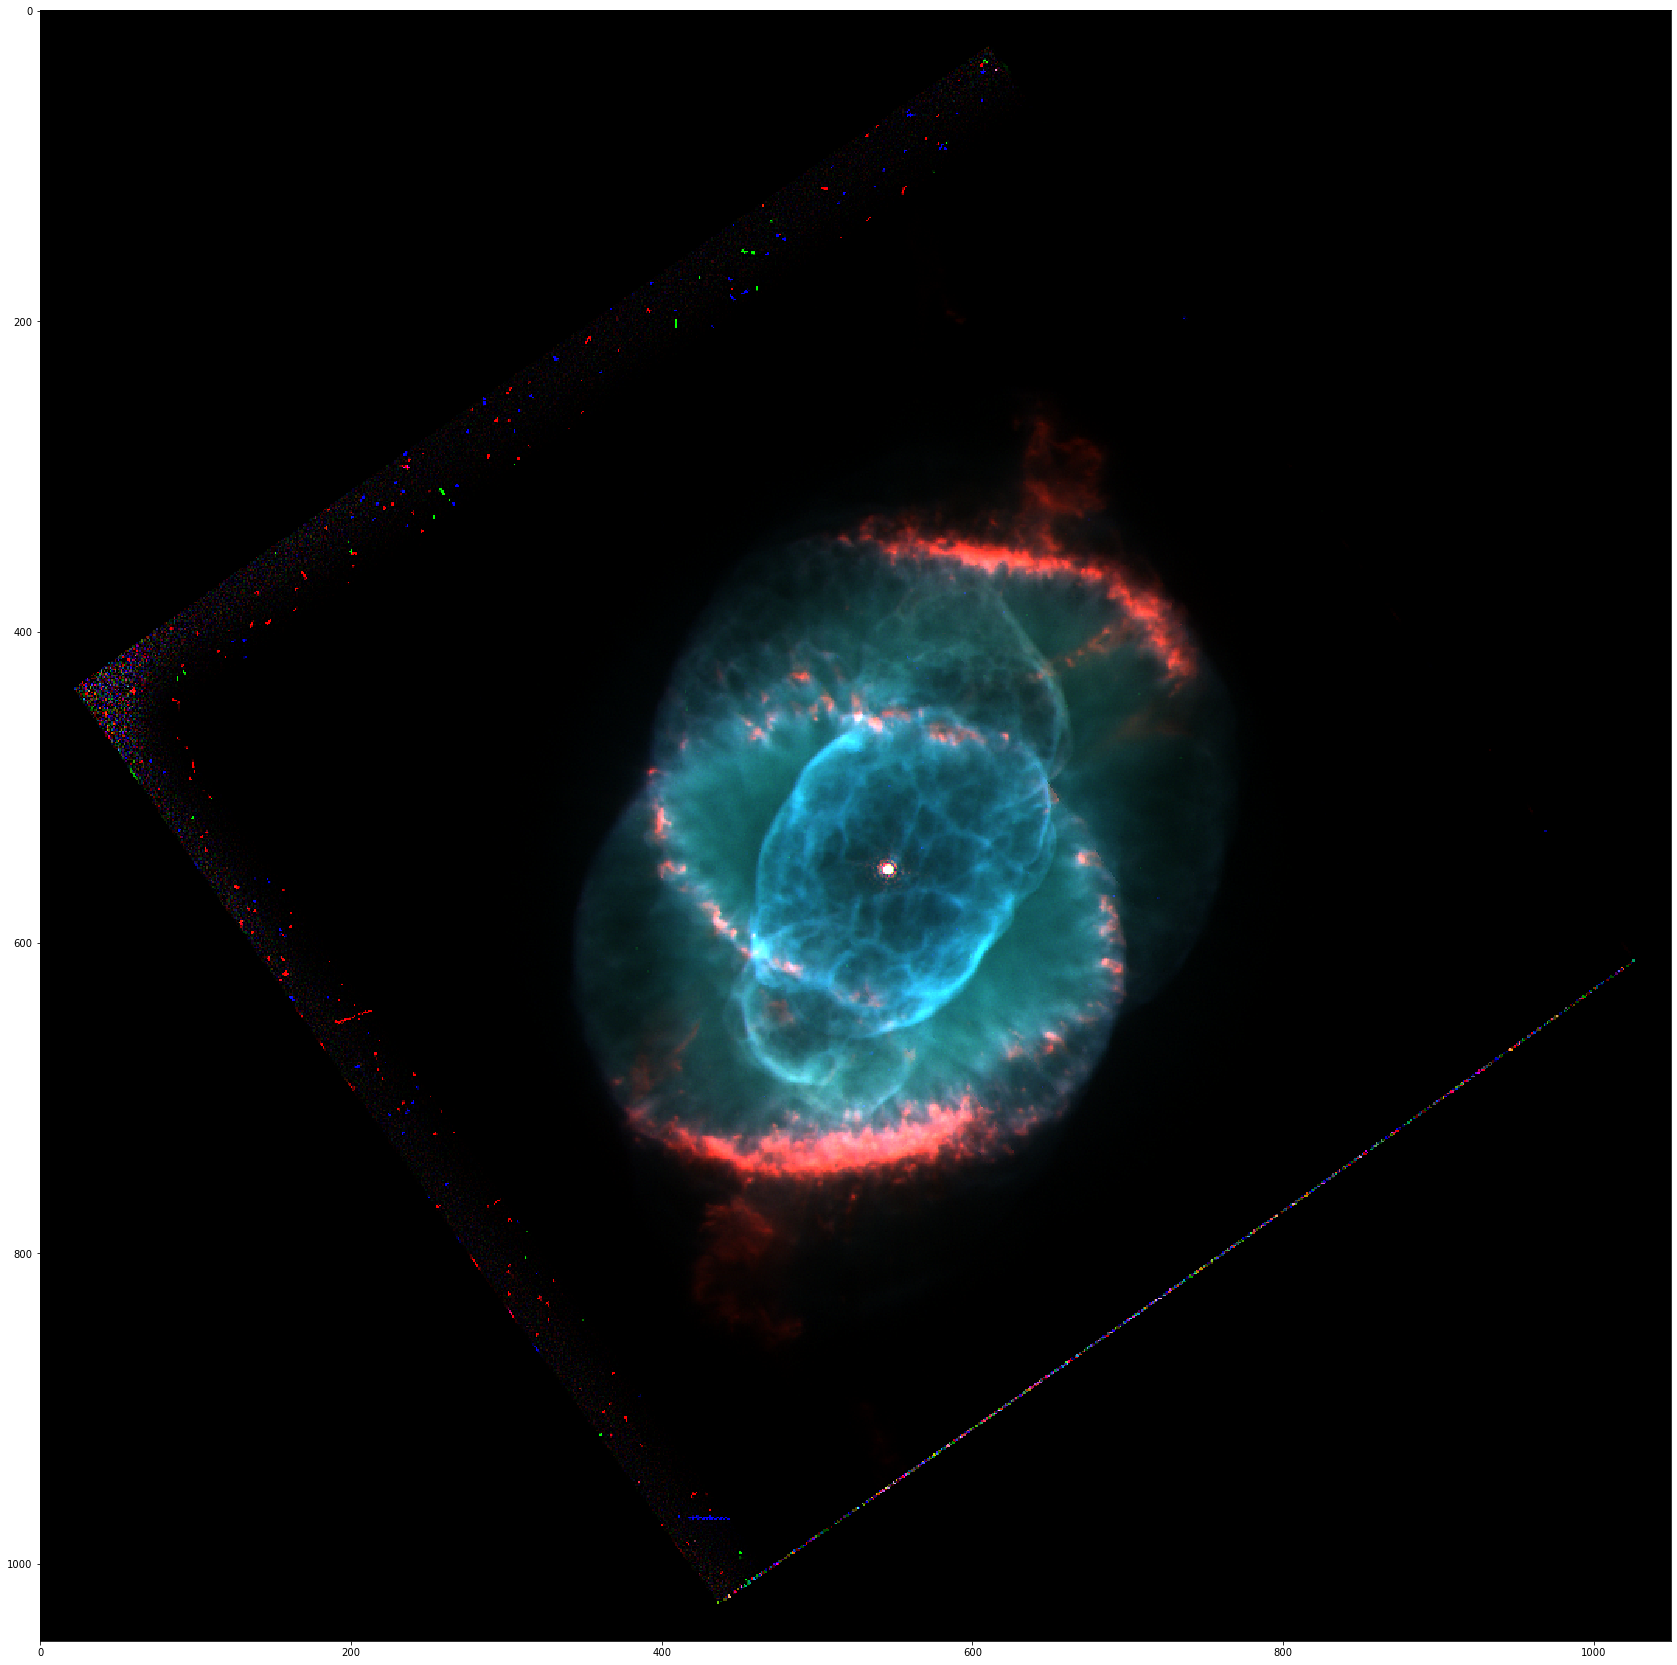

In [176]:
img_ch_2 = img_ch_load.filter(ImageFilter.SHARPEN)
fig, axes = plt.subplots(figsize=(30,30))

axes.imshow(img_ch_2)

img_ch_2.save(out + 'rgb_sh.png')

plt.show()

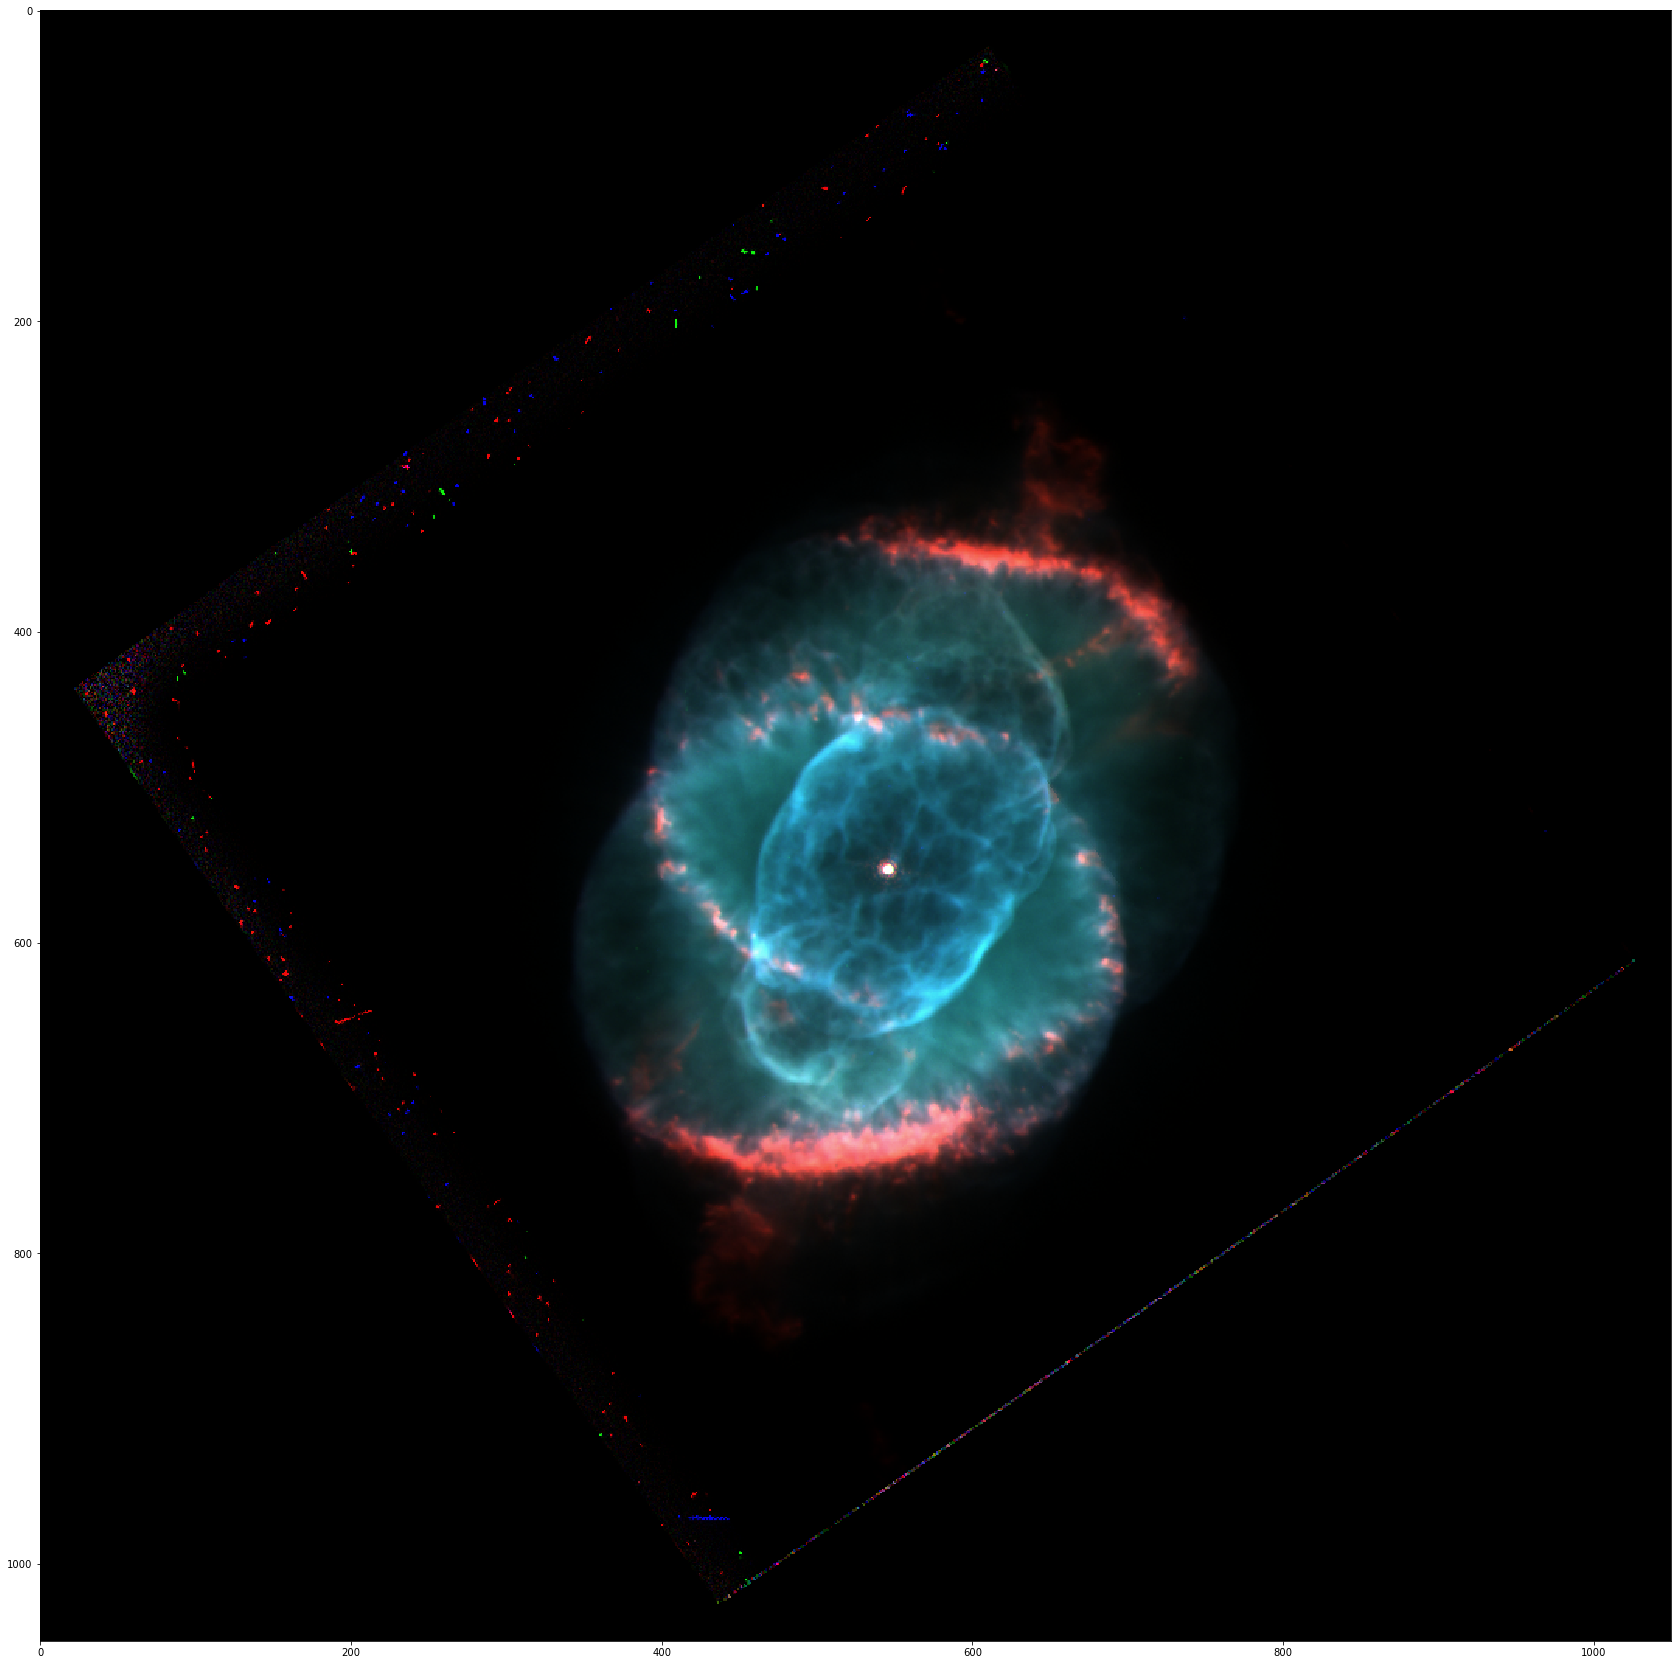

In [172]:
converter = ImageEnhance.Color(img_ch_load)
img_ch_2 = converter.enhance(0.9)
fig, axes = plt.subplots(figsize=(30,30))

axes.imshow(img_ch_2)

plt.show()